In [3]:
import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import flammkuchen as fl
import pandas as pd

%matplotlib widget

In [2]:
data_dir = Path("/Users/vigji/Desktop/dest_dir/18042024")


def _find_sorted_files(data_path, camera_names, extension=".h5"):
    data_path = Path(data_path)
    return [
        next(data_path.glob(f"*{camera_name}*{extension}"))
        for camera_name in camera_names
    ]

In [22]:
params_path = data_dir / "calibration_vals" / "camera_params_adj.h5"
adj_extrinsics_loaded, adj_intrinsics_loaded, camera_names = mcc.load_calibration(
    str(params_path), load_format="gimbal"
)
n_cams = len(camera_names)

In [23]:
calibration_dir = next((data_dir / "Calibration").glob("*cropped"))

checkerboard_files = _find_sorted_files(calibration_dir, camera_names)
calibration_video_len = 11858

In [38]:
uvs = fl.load(checkerboard_files[0])["uvs"]
n_points = uvs.shape[1]
checkbd_data_uvs = np.zeros((n_cams, calibration_video_len, n_points, 2)) * np.nan

for i, data_file in enumerate(checkerboard_files):
    checkbd_data = fl.load(data_file)  # ["qc_data"].shape
    uvs = checkbd_data["uvs"]
    indexes = checkbd_data["frame_ixs"]
    checkbd_data_uvs[i, indexes, :, :] = uvs

all_triang = []
for i in tqdm(range(n_points)):
    all_triang.append(
        mcc.triangulate(
            checkbd_data_uvs[:, :, i, :], adj_extrinsics_loaded, adj_intrinsics_loaded
        )
    )
all_triang = np.array(all_triang)

100%|██████████| 35/35 [00:27<00:00,  1.27it/s]


In [46]:
triangulated_dir = data_dir / "triangulations"
triangulated_dir.mkdir(exist_ok=True)
np.save(triangulated_dir / "calibration.npy", all_triang)

In [87]:
mouse_data_dirs = list(data_dir.glob("M10"))

for mouse_data_dir in mouse_data_dirs:
    print(mouse_data_dir.name)
    dlc_files = _find_sorted_files(mouse_data_dir, camera_names)

    dlc_file = dlc_files[0]
    dlc_data_df = pd.read_hdf(dlc_file)
    kpoints = dlc_data_df.columns.levels[1]
    n_frames = len(dlc_data_df)

    checkbd_data_uvs = np.zeros((n_cams, n_frames, len(kpoints), 2)) * np.nan

    for i, dlc_file in enumerate(dlc_files):
        dlc_data_df = pd.read_hdf(dlc_file)
        dlc_data_df.columns = dlc_data_df.columns.droplevel(0)
        for i, kp in enumerate(kpoints):
            for i_coord, coord in enumerate(["x", "y"]):
                checkbd_data_uvs[:, :, i, i_coord] = dlc_data_df[(kp, coord)].values

    all_triang = []
    for i, kp in tqdm(list(enumerate(kpoints))):
        all_triang.append(
            mcc.triangulate(
                checkbd_data_uvs[:, :, i, :],
                adj_extrinsics_loaded,
                adj_intrinsics_loaded,
            )
        )
    all_triang = np.array(all_triang)
    np.save(triangulated_dir / f"{mouse_data_dir.name}.npy", all_triang)

M10


100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


In [88]:
np.save(triangulated_dir / f"keypoints.npy", kpoints)

## Visualizations

In [4]:
triangulated_dir = Path("/Users/vigji/Desktop/dest_dir/18042024/triangulations")
example_file = triangulated_dir / "M8.npy"

keypoints = np.load(triangulated_dir / "keypoints.npy", allow_pickle=True)
example_data = np.load(example_file, allow_pickle=True)

In [5]:
n_pts = 1000

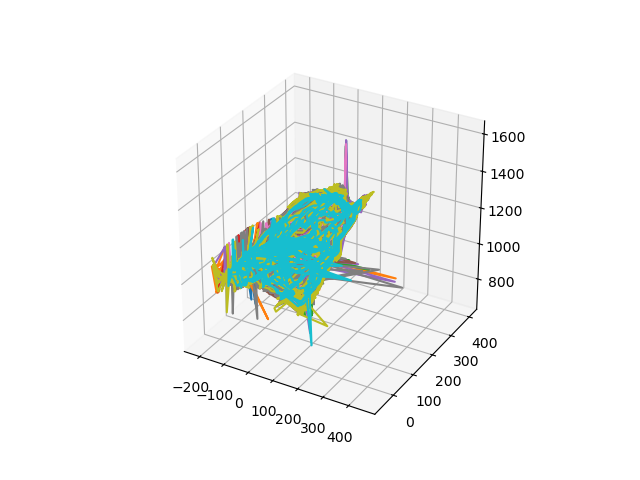

In [6]:
sl = slice(0, 10000)

ax = plt.figure().add_subplot(projection="3d")
for kp_idx in range(10):
    ax.plot(
        example_data[kp_idx, sl, 0],
        example_data[kp_idx, sl, 1],
        example_data[kp_idx, sl, 2],
    )
# set equal aspect ratio
ax.set_box_aspect([1, 1, 1])

In [7]:
keypoints

array(['Blimbmid', 'Flimbmid', 'LBlimb', 'LFlimb', 'Lear', 'RBlimb',
       'RFlimb', 'Rear', 'nose', 'tailbase'], dtype=object)

In [8]:
from movement.io.validators import ValidPosesDataset
from movement.io.load_poses import _from_valid_data

skeleton = [
    ["Blimbmid", "LBlimb"],
    ["Blimbmid", "RBlimb"],
    ["Blimbmid", "Flimbmid"],
    ["Flimbmid", "LFlimb"],
    ["Flimbmid", "RFlimb"],
    ["Blimbmid", "tailbase"],
    ["Flimbmid", "Lear"],
    ["Flimbmid", "Rear"],
    ["Rear", "nose"],
    ["Lear", "nose"],
]


def movement_df_from_data(data, keypoints, conf_array=None, fps=60):
    data = data.swapaxes(0, 1)[:, np.newaxis, :, :]
    n_frames = data.shape[0]
    n_keypoints = data.shape[2]

    if conf_array is None:
        conf_array = np.ones((n_frames, 1, n_keypoints))

    return _from_valid_data(
        ValidPosesDataset(
            position_array=data,
            confidence_array=conf_array,
            individual_names=[""],
            keypoint_names=keypoints,
            fps=fps,
        )
    )


dataset = movement_df_from_data(example_data, keypoints)
dataset.attrs["skeleton"] = skeleton

position_xarr = dataset["position"]
position_xarr.sel(keypoints="Blimbmid", individuals="")
# drop the individual dimension:
position_xarr = position_xarr.squeeze("individuals", drop=True)

In [9]:
import xarray as xr

# Sample data for demonstration
n_frames = 10
n_keypoints = 6
space_dimensions = 3
xarr = np.random.rand(n_frames, n_keypoints, space_dimensions)  # Random 3D coordinates

# Define a skeleton
skeleton = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


# Function to interpolate without loops
def interpolate_broadcast(p1, p2, num_points=5):
    """
    Perform linear interpolation between two arrays of points without explicit loops over frames.
    p1, p2: numpy arrays with shape (n_frames, num_pairs, space_dimensions)
    num_points: number of intermediate points to interpolate
    Returns an array of shape (n_frames, num_pairs, num_points, space_dimensions)
    """
    # Generating the interpolation coefficients
    t = np.linspace(0, 1, num=num_points + 2, endpoint=True)[1:-1].reshape(
        1, 1, num_points, 1
    )
    return p1[..., np.newaxis, :] * (1 - t) + p2[..., np.newaxis, :] * t


def interpolate_numpy_skeleton(data_arr, skeleton, num_points=10, concatenate=True):
    """Interpolate a skeleton of keypoints across all frames.

    Parameters
    ----------
    xarr : np.ndarray
        Data to interpolate
    skeleton :
        _description_
    num_points : _type_
        _description_

    Returns
    -------
    np.array
        An array of shape (n_frames, num_pairs, num_points, space_dimensions)
    """

    # Convert skeleton index pairs into NumPy arrays for advanced indexing
    kp1_indices, kp2_indices = zip(*skeleton)
    kp1_indices = np.array(kp1_indices)
    kp2_indices = np.array(kp2_indices)

    # Extract coordinates of the keypoints pairs across all frames
    points1 = data_arr[
        :, kp1_indices, :
    ]  # Shape (n_frames, len(skeleton), space_dimensions)
    points2 = data_arr[
        :, kp2_indices, :
    ]  # Shape (n_frames, len(skeleton), space_dimensions)

    # Interpolate points:
    interpolated = interpolate_broadcast(points1, points2, num_points=num_points)

    if concatenate:
        return np.concatenate(
            [interpolated[:, :, i, :] for i in range(num_points)], axis=1
        )
    else:
        return interpolated


def interpolate_xarray_skeleton(dataset, num_points=10, concatenate=True):
    data_xarr = dataset["position"]

    if "individuals" in data_xarr.dims:
        data_xarr = data_xarr.squeeze("individuals", drop=True)

    # numpy from xarr:
    data_arr = data_xarr.values
    skeleton = dataset.attrs.get("skeleton", None)
    # read labels from kepypoints dimension:
    labels = list(data_xarr.coords["keypoints"].values)

    # map labels to indices in skeleton:
    skeleton = [(labels.index(kp1), labels.index(kp2)) for kp1, kp2 in skeleton]

    return interpolate_numpy_skeleton(
        data_arr, num_points=num_points, skeleton=skeleton, concatenate=concatenate
    )


interpolated_points = interpolate_numpy_skeleton(xarr, num_points=5, skeleton=skeleton)

In [10]:
interpolated_points = interpolate_xarray_skeleton(dataset, num_points=10)

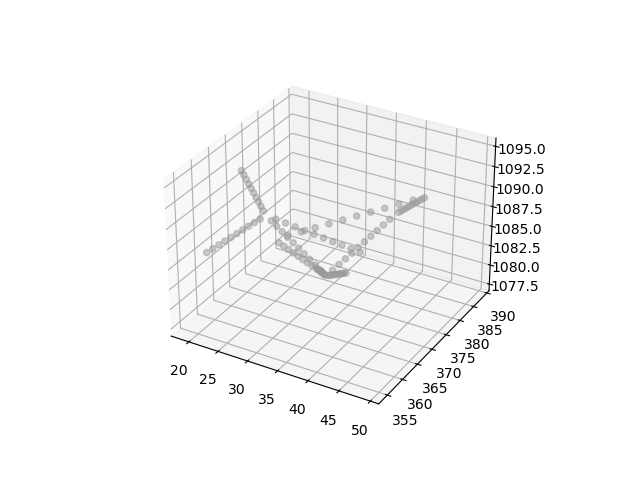

In [11]:
i = 800
ax = plt.figure().add_subplot(projection="3d")
# for p in pair:
# ax.scatter(xarr[i, p, 0], xarr[i, p, 1], xarr[i, p, 2], c=f"C{i_pair}", alpha=0.5)
# data = dataset["position"].sel(keypoints=pair, individuals="").values
ax.scatter(
    interpolated_points[i, :, 0],
    interpolated_points[i, :, 1],
    interpolated_points[i, :, 2],
    c=".6",
    alpha=0.5,
)

In [12]:
# all_triang[kp_idx, sl, 0]
timepts = interpolated_points.shape[0]
time_arr = np.stack(
    [
        np.arange(timepts),
    ]
    * interpolated_points.shape[1]
).T
to_plot = np.concatenate([time_arr[:, :, np.newaxis], interpolated_points], 2)

to_plot = to_plot.reshape(-1, 4)

In [13]:
%gui qt
import napari

In [14]:
v = napari.Viewer()

v.add_points(data=to_plot, size=5)

<Points layer 'to_plot' at 0x31c4c33d0>

In [15]:
# fabio export:
np.array(dataset["position"])[:, 0, :, :].shape

# concatenate all over keypoints:
concat = np.concatenate(
    [np.array(dataset["position"])[:, 0, i, :] for i in range(10)], axis=1
)

In [35]:
pd.DataFrame(concat).to_csv(
    "/Users/vigji/Desktop/fabio_test_coords.csv", index=False, header=False
)

In [38]:
dataset.coords["keypoints"].values

array(['Blimbmid', 'Flimbmid', 'LBlimb', 'LFlimb', 'Lear', 'RBlimb',
       'RFlimb', 'Rear', 'nose', 'tailbase'], dtype='<U8')

In [36]:
9, 0, 2
9, 0, 5
0, 1, 2
0, 1, 5
0, 1, 3
0, 1, 6
1, 4, 3
1, 6, 7
1, 4, 7
4, 7, 8

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

In [7]:
import numpy as np
from skimage import data

import napari

blobs = data.binary_blobs(
    length=128, blob_size_fraction=0.05, n_dim=4, volume_fraction=0.05
)
# layer = viewer.add_shapes(
#     path, shape_type='path', edge_width=4, edge_color=['red', 'blue']
# )

Path (6, 3)


In [9]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(blobs.astype(float))

# sample vector coord-like data
path = np.array(
    [
        [0, 0, 0, 0],
        [1, 0, 10, 10],
        [2, 0, 5, 15],
        [3, 20, 5, 15],
        [4, 56, 70, 21],
        [5, 127, 127, 127],
    ]
)

print("Path", path.shape)

layer = viewer.add_shapes(path, shape_type="path", edge_width=4, edge_color=["red"])

Path (6, 4)
